# Text Mining


**1. [Imports](#1)**
   - [1.1. Libraries](#1.1)
   - [1.2. Datasets](#1.2)

**2. [Data Understanding](#2)**

**3. [Preprocessing](#3)**
- [3.1. Word Count](#3.1)
- [3.2. Clean Text](#3.2)
    - [3.2.1. Tokenization](#3.2.1)
    - [3.2.2. Punctuation](#3.2.2)
    - [3.2.3. Lowercasing](#3.2.3)
    - [3.2.4. Stopwords](#3.2.4)
    - [3.2.5. Stemming and Lemmatization](#3.2.5)
    - [3.2.6. Function](#3.2.6)

**4. [Feature Engineering](#4)**
- [4.1. Train](#4.1)
- [4.2. Test](#4.2)

**5. [Model Training and Evaluation](#5)**
- [5.1. Logistic Regression](#5.1)
- [5.1. Naive Bayes](#5.2)



 <a class="anchor" id="#1">

# 1. Imports

</a>

 <a class="anchor" id="#1.1">

## 1.1. Libraries

</a>


In [238]:
!pip install wordcloud

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

#Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Evaluation
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

 <a class="anchor" id="#1.2">

## 1.2. Datasets

</a>

In [240]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

 <a class="anchor" id="#2">

# 2. Data Understanding

</a>

In [241]:
train

text  label
0     $BYND - JPMorgan reels in expectations on Beyo...      0
1     $CCL $RCL - Nomura points to bookings weakness...      0
2     $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3     $ESS: BTIG Research cuts to Neutral https://t....      0
4     $FNKO - Funko slides after Piper Jaffray PT cu...      0
...                                                 ...    ...
9538  The Week's Gainers and Losers on the Stoxx Eur...      2
9539  Tupperware Brands among consumer gainers; Unil...      2
9540  vTv Therapeutics leads healthcare gainers; Myo...      2
9541    WORK, XPO, PYX and AMKR among after hour movers      2
9542             YNDX, I, QD and OESX among tech movers      2

[9543 rows x 2 columns]

In [242]:
test

id                                               text
0        0  ETF assets to surge tenfold in 10 years to $50...
1        1  Here‚Äôs What Hedge Funds Think Evolution Petrol...
2        2  $PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3        3  China is in the process of waiving retaliatory...
4        4  Highlight: ‚ÄúWhen growth is scarce, investors s...
...    ...                                                ...
2383  2383  $IVC - Invacare Corporation (IVC) CEO Matthew ...
2384  2384       Domtar EPS misses by $0.05,  revenue in-line
2385  2385  India Plans Incentives to Bring In Foreign Man...
2386  2386  $NVCR shows institutional accumulation with bl...
2387  2387  accesso Technology : Form 8.3 - Accesso Techno...

[2388 rows x 2 columns]

In [243]:
print(train.shape, test.shape)

(9543, 2) (2388, 2)


In [244]:
print(train.isna().sum())
print(test.isna().sum())

text     0
label    0
dtype: int64
id      0
text    0
dtype: int64


In [245]:
set(train['label'].values)

{0, 1, 2}

In [246]:
train['label'].mean()

1.496279995808446

In [247]:
train['label'].std()

0.7431386657201221

In [248]:
train['label'].median()

2.0

In [249]:
train['label'].describe()

count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

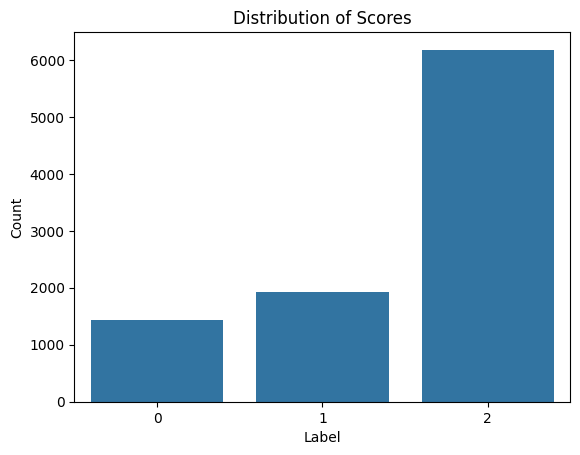

In [250]:
# Visualize distribution of satisfaction
sns.countplot(data=train, x='label')
plt.title("Distribution of Scores")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

<Axes: >

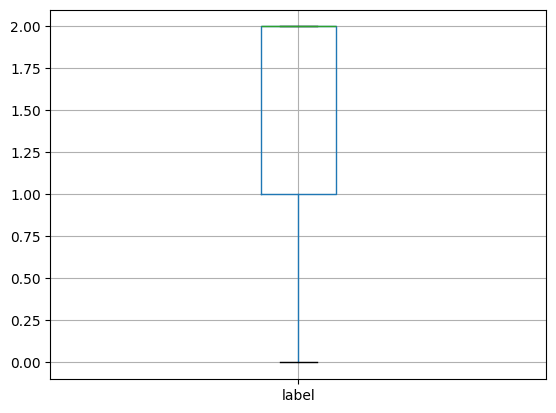

In [251]:
train.boxplot(['label'])

 <a class="anchor" id="#3">

# 3. Preprocessing

</a>

In [252]:
train['Sentiment_label'] = train['label'].apply(lambda x: 'Bullish' if x == 0 else ('Bearish' if x == 1 else 'Neutral'))

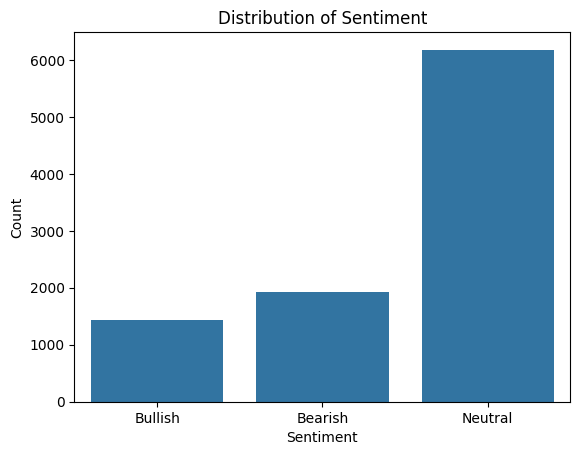

In [253]:
sns.countplot(data=train, x='Sentiment_label')
plt.title("Distribution of Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()
# 2. Data Preprocessing
## Text Preprocessing
train['text'] = train['text'].apply(lambda x: x.lower())

In [254]:
#Check a rabdom text entry
train['text'][20]

'$ncbs: hovde group cuts to market perform'

 <a class="anchor" id="#3.1">

## 3.1. Word Count

</a>

In [255]:
train['word_count']  = train['text'].apply(lambda x: len(str(x).split(" ")))
train[['text','word_count']].head()

text  word_count
0  $bynd - jpmorgan reels in expectations on beyo...          10
1  $ccl $rcl - nomura points to bookings weakness...          14
2  $cx - cemex cut at credit suisse, j.p. morgan ...          14
3  $ess: btig research cuts to neutral https://t....           7
4  $fnko - funko slides after piper jaffray pt cu...          10

In [256]:
train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

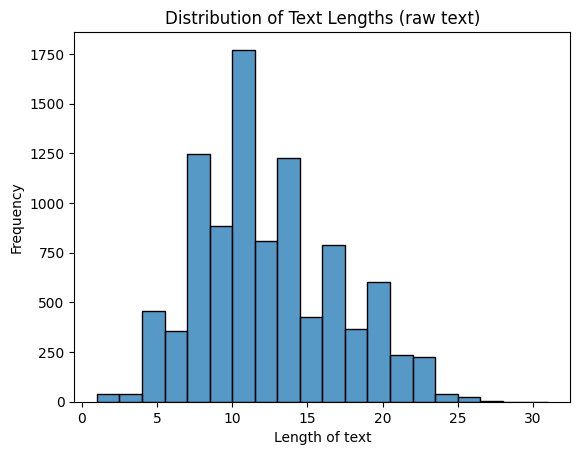

In [257]:
#Plot distribution of text length
sns.histplot(train['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

In [258]:
all_words = ' '.join(train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2625
the    2496
of     1660
in     1578
-      1390
on     1355
a      1311
for    1211
and    1011
is      862
Name: count, dtype: int64

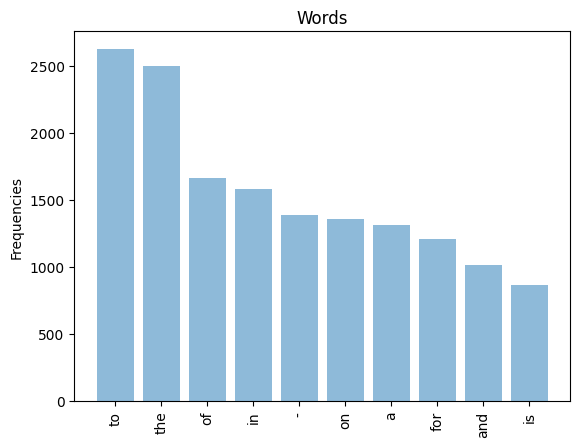

In [259]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

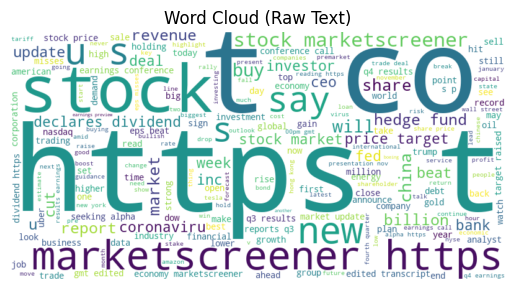

In [260]:
# üå•Ô∏è Create a word cloud from the raw text
raw_text = ' '.join(train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

 <a class="anchor" id="#3.2">

## 3.2. Clean Text

</a>

 <a class="anchor" id="#3.2.1">

### 3.2.1. Tokenization

</a>

In [261]:
train['tokens'] = train['text'].apply(word_tokenize)
all_tokens = train['text'].apply(word_tokenize).explode().tolist()


 <a class="anchor" id="3.2.2">

### 3.2.2. Punctuation

</a>

In [262]:
exclude = set(string.punctuation)

In [263]:
print([word for word in all_tokens if word not in exclude])

['bynd', 'jpmorgan', 'reels', 'in', 'expectations', 'on', 'beyond', 'meat', 'https', '//t.co/bd0xbfgjkt', 'ccl', 'rcl', 'nomura', 'points', 'to', 'bookings', 'weakness', 'at', 'carnival', 'and', 'royal', 'caribbean', 'https', '//t.co/ygjpt2red3', 'cx', 'cemex', 'cut', 'at', 'credit', 'suisse', 'j.p.', 'morgan', 'on', 'weak', 'building', 'outlook', 'https', '//t.co/kn1g4awfib', 'ess', 'btig', 'research', 'cuts', 'to', 'neutral', 'https', '//t.co/mcyftsxc2n', 'fnko', 'funko', 'slides', 'after', 'piper', 'jaffray', 'pt', 'cut', 'https', '//t.co/z37ijmcqzb', 'fti', 'technipfmc', 'downgraded', 'at', 'berenberg', 'but', 'called', 'top', 'pick', 'at', 'deutsche', 'bank', 'https', '//t.co/xkcpdiliuu', 'gm', 'gm', 'loses', 'a', 'bull', 'https', '//t.co/tdufg5hbxy', 'gm', 'deutsche', 'bank', 'cuts', 'to', 'hold', 'https', '//t.co/7fv1zifzbs', 'gtt', 'cowen', 'cuts', 'to', 'market', 'perform', 'hnhaf', 'hnhpd', 'aapl', 'trendforce', 'cuts', 'iphone', 'estimate', 'after', 'foxconn', 'delay', 'http

In [264]:
list_tokens = [word for word in all_tokens if word not in exclude]

 <a class="anchor" id="3.2.3">

### 3.2.3. Lowercasing

</a>

In [265]:
train['text'].str.lower()

0       $bynd - jpmorgan reels in expectations on beyo...
1       $ccl $rcl - nomura points to bookings weakness...
2       $cx - cemex cut at credit suisse, j.p. morgan ...
3       $ess: btig research cuts to neutral https://t....
4       $fnko - funko slides after piper jaffray pt cu...
                              ...                        
9538    the week's gainers and losers on the stoxx eur...
9539    tupperware brands among consumer gainers; unil...
9540    vtv therapeutics leads healthcare gainers; myo...
9541      work, xpo, pyx and amkr among after hour movers
9542               yndx, i, qd and oesx among tech movers
Name: text, Length: 9543, dtype: object

In [266]:
all_tokens = [word.lower() for word in all_tokens]

 <a class="anchor" id="#3.2.4">

### 3.2.4. Stopwords

</a>

In [267]:
stop = set(stopwords.words('english'))

In [268]:
[word for word in all_tokens if word not in stop]

['$',
 'bynd',
 '-',
 'jpmorgan',
 'reels',
 'expectations',
 'beyond',
 'meat',
 'https',
 ':',
 '//t.co/bd0xbfgjkt',
 '$',
 'ccl',
 '$',
 'rcl',
 '-',
 'nomura',
 'points',
 'bookings',
 'weakness',
 'carnival',
 'royal',
 'caribbean',
 'https',
 ':',
 '//t.co/ygjpt2red3',
 '$',
 'cx',
 '-',
 'cemex',
 'cut',
 'credit',
 'suisse',
 ',',
 'j.p.',
 'morgan',
 'weak',
 'building',
 'outlook',
 'https',
 ':',
 '//t.co/kn1g4awfib',
 '$',
 'ess',
 ':',
 'btig',
 'research',
 'cuts',
 'neutral',
 'https',
 ':',
 '//t.co/mcyftsxc2n',
 '$',
 'fnko',
 '-',
 'funko',
 'slides',
 'piper',
 'jaffray',
 'pt',
 'cut',
 'https',
 ':',
 '//t.co/z37ijmcqzb',
 '$',
 'fti',
 '-',
 'technipfmc',
 'downgraded',
 'berenberg',
 'called',
 'top',
 'pick',
 'deutsche',
 'bank',
 'https',
 ':',
 '//t.co/xkcpdiliuu',
 '$',
 'gm',
 '-',
 'gm',
 'loses',
 'bull',
 'https',
 ':',
 '//t.co/tdufg5hbxy',
 '$',
 'gm',
 ':',
 'deutsche',
 'bank',
 'cuts',
 'hold',
 'https',
 ':',
 '//t.co/7fv1zifzbs',
 '$',
 'gtt',
 ':

In [269]:
[word for word in all_tokens if word in stop]

['in',
 'on',
 'to',
 'at',
 'and',
 'at',
 'on',
 'to',
 'after',
 'at',
 'but',
 'at',
 'a',
 'to',
 'to',
 'after',
 'on',
 'on',
 'i',
 'to',
 'at',
 'to',
 'of',
 'to',
 'at',
 'on',
 'from',
 'the',
 'to',
 'out',
 'a',
 'in',
 'on',
 'more',
 'in',
 'to',
 'to',
 'on',
 'to',
 'from',
 'at',
 'and',
 'at',
 'on',
 'to',
 'from',
 'at',
 'to',
 'from',
 'at',
 'to',
 'from',
 'at',
 'to',
 'from',
 'at',
 'at',
 't',
 'by',
 'to',
 'on',
 'the',
 'at',
 't',
 'after',
 'at',
 't',
 'after',
 'to',
 'from',
 'at',
 'to',
 'from',
 'at',
 'of',
 'for',
 'on',
 'to',
 'from',
 'at',
 'to',
 'from',
 'at',
 'to',
 'from',
 'at',
 'to',
 'from',
 'at',
 'to',
 'in',
 'from',
 'at',
 'to',
 'from',
 'at',
 'to',
 'from',
 'at',
 'to',
 'from',
 'at',
 'as',
 'at',
 'to',
 'from',
 'at',
 'are',
 'their',
 'here',
 'what',
 'you',
 'to',
 'to',
 'from',
 'at',
 'to',
 'from',
 'at',
 'on',
 'not',
 'be',
 'as',
 'to',
 'o',
 'on',
 'after',
 'just',
 'and',
 'are',
 'their',
 'and',
 'i

In [270]:
list_tokens = [word for word in all_tokens if word not in stop]

 <a class="anchor" id="#3.2.5">

### 3.2.5. Stemming and Lemmatization

</a>

In [271]:
stemmer = SnowballStemmer('english')

In [272]:
lemma = WordNetLemmatizer()

In [273]:
#for word in list_tokens:
 #   print(f"Lemma of {word} is {lemma.lemmatize(word)}")
  #  print(f"Stem of {word} is {stemmer.stem(word)}")
   # print('--------------------New word----------------')

 <a class="anchor" id="#3.2.6">

### 3.2.6. Function

</a>

In [274]:
nltk.download('stopwords')
nltk.download('wordnet')
def clean(text_list, lemmatize, stemmer):

    updates = []

    for j in tqdm(text_list):

        text = j

        #LOWERCASE TEXT
        text = text.lower()

        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        # [^&] - Returns a match for any character EXCEPT &.
        # a-zA-Z - Returns a match for any character alphabetically between a and z, lower case or upper case.
        text = re.sub("br", "", text)  # remove "br"
        text = re.sub(r'http\S+', '', text)  # remove URLs
        text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  # remove punctuation


        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])

        #Lemmatize
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())

        #Stemming
        if stemmer:
            text = " ".join(stemmer.stem(word) for word in text.split())

        updates.append(text)

    return updates

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\duart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\duart\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 <a class="anchor" id="#3.3">

## 3.3. Train - Test Split

</a>

In [275]:
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['label'], test_size=0.20, random_state=4)

In [276]:
len(X_train), len(X_test)

(7634, 1909)

In [277]:
len(y_train), len(y_test)

(7634, 1909)

In [278]:
X_train

8129          why nio hasn‚Äôt fallen totally off the cliff
2100    negative-yield bond pool declines as hopes for...
3635    eur/usd bearish impulse and flag aims at 1.094...
791                  canadian national laying off workers
7814    $bgr - blackrock energy & resources trust: buy...
                              ...                        
456     imf encouraged by recovery in china, but pande...
6017    ebay sells stubhub to ticket marketplace viago...
709     the man about to become britain's top central ...
8366                6 stocks with a low price-sales ratio
1146    $ruth - ruth's hospitality group (ruth) invest...
Name: text, Length: 7634, dtype: object

In [279]:
y_train

8129    1
2100    1
3635    0
791     0
7814    1
       ..
456     2
6017    2
709     2
8366    2
1146    2
Name: label, Length: 7634, dtype: int64

In [280]:
X_train_clean = clean(X_train, lemmatize=True, stemmer=False)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7634/7634 [00:00<00:00, 11574.89it/s]


In [281]:
X_test_clean = clean(X_test, lemmatize=True, stemmer=False)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1909/1909 [00:00<00:00, 15483.27it/s]


 <a class="anchor" id="#4">

# 4. Feature Engineering

</a>

In [282]:
TfidfVectorizer

sklearn.feature_extraction.text.TfidfVectorizer

In [283]:
tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1,1))

 <a class="anchor" id="#4.1">

## 4.1. Train

</a>

In [284]:
X = tfidf.fit_transform(X_train_clean).toarray()

In [285]:
tfidf.get_feature_names_out()

array(['aa', 'aaa', 'aac', ..., 'zzucotee', 'zzz', 'zzzi'], dtype=object)

In [286]:
#Get a dictionary that maps each word (token) to its index (position) in the vectorized feature space.
tfidf.vocabulary_

{'nio': 9902,
 'fallen': 4917,
 'totally': 14758,
 'cliff': 2482,
 'negative': 9769,
 'yield': 16772,
 'bond': 1719,
 'pool': 11293,
 'decline': 3385,
 'hope': 6521,
 'global': 5798,
 'recovery': 12154,
 'soar': 13614,
 'co': 2573,
 'ycfxlazf': 16703,
 'eur': 4674,
 'usd': 15376,
 'bearish': 1374,
 'impulse': 6979,
 'flag': 5197,
 'aim': 369,
 'target': 14336,
 'canadian': 2003,
 'national': 9687,
 'laying': 8261,
 'worker': 16289,
 'bgr': 1492,
 'blackrock': 1610,
 'energy': 4456,
 'resource': 12370,
 'trust': 14927,
 'buy': 1886,
 'yielding': 16773,
 'cef': 2187,
 'upside': 15340,
 'oil': 10336,
 'read': 12090,
 'get': 5692,
 'update': 15320,
 'ucvw': 15087,
 'trump': 14924,
 'fy': 5525,
 'budget': 1823,
 'proposal': 11539,
 'plan': 11165,
 'rise': 12541,
 'defense': 3410,
 'spending': 13750,
 'hedge': 6278,
 'fund': 5483,
 'open': 10449,
 'kimono': 7942,
 'popular': 11302,
 'software': 13636,
 'stock': 13939,
 'right': 12516,
 'heading': 6254,
 'tokyo': 14727,
 'week': 16035,
 'expl

In [287]:
#Get the IDF (Inverse Document Frequency) score for each feature (term) in the same order as the vocabulary.
idf_dict = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

# Get the first 10 items
idf_dict_10 = dict(list(idf_dict.items())[4100:4110])

print(idf_dict_10)

{'eaches': 9.247351037092788, 'ead': 9.247351037092788, 'eadsf': 9.247351037092788, 'eadsy': 9.247351037092788, 'eadwinners': 9.247351037092788, 'eaevr': 9.247351037092788, 'eaewzp': 9.247351037092788, 'eagle': 7.861056675972897, 'eahxhyaocy': 9.247351037092788, 'eaizefmitx': 9.247351037092788}


In [288]:
X.shape

(7634, 17211)

In [289]:
y = y_train.to_numpy()

 <a class="anchor" id="#4.2">

## 4.2. Test

</a>

In [290]:
X_test = tfidf.transform(X_test_clean).toarray()

 <a class="anchor" id="#5">

# 5. Model Training and Evaluation

</a>

 <a class="anchor" id="%5.1">

## 5.1. Logistic Regression

</a>

In [291]:
model_lr = LogisticRegression(class_weight='balanced', max_iter=1000, C=0.1)

# If using validation:
model_lr.fit(X_train, y_train)

ValueError: could not convert string to float: 'why nio hasn‚Äôt fallen totally off the cliff'

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on training data
train_preds = model.predict(X_tr)
print("Training set evaluation:")
print("Accuracy:", accuracy_score(y_tr, train_preds))
print(classification_report(y_tr, train_preds))

# Predict on validation data
val_preds = model.predict(X_val)
print("Validation set evaluation:")
print("Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))

 <a class="anchor" id="#5.2">

## 5.2. Naive Bayes

</a>

In [ ]:
nb = GaussianNB()

In [ ]:
nb.fit(X, y)

In [ ]:
nb_pred = nb.predict(x_test)

In [ ]:
print(classification_report(y_test, nb_pred))

In [ ]:
confusion_matrix(nb_pred, y_test)

Attributes
1) Check the probability of each class
2) Verify the number of training samples observed in each class

In [ ]:
nb.class_prior_

In [ ]:
nb.class_count_

# Pre-processing and tokenization

In [ ]:
# üß† Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\duart\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\duart\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\duart\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\duart\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\duart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\duart\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
stop = set(stopwords.words('english'))

In [ ]:
# Stemming and Lemmatization
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [ ]:
updates = clean(train['text'], lemmatize = True, stemmer = False)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9543/9543 [00:07<00:00, 1258.31it/s]


In [ ]:
updates[40]

'autodesk downgraded underweight neutral jpmorgan'

In [ ]:
train['text'][40]

'autodesk downgraded to underweight from neutral at jpmorgan'

In [ ]:
def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"text": list_updated}))

In [ ]:
amazon_df_train = train.drop(['label'], axis=1)
update_df(train, updates)
train.head()

text  label Sentiment_lable  \
0  bynd jpmorgan reel expectation beyond meat co ...      0         Bullish   
1  ccl rcl nomura point booking weakness carnival...      0         Bullish   
2  cx cemex cut credit suisse j p morgan weak bui...      0         Bullish   
3         es btig research cut neutral co mcyftsxc n      0         Bullish   
4  fnko funko slide piper jaffray pt cut co z ijm...      0         Bullish   

   word_count  
0          10  
1          14  
2          14  
3           7  
4          10

# Define training feature - Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [ ]:
bow = CountVectorizer(binary=True)
X = bow.fit_transform(train["text"])

In [ ]:
X

<9543x19904 sparse matrix of type '<class 'numpy.int64'>'
	with 88252 stored elements in Compressed Sparse Row format>

In [ ]:
print(X[5:10].toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
y = np.array(train['label'])

In [ ]:
y[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
print(bow.get_feature_names_out()[100:150])

['accretive' 'accumulated' 'accumulating' 'accumulation' 'accuracy'
 'accurately' 'accusation' 'accused' 'accuses' 'acd' 'ace' 'acea'
 'acelerada' 'acelrx' 'ach' 'achieve' 'achieved' 'achieves' 'achieving'
 'achv' 'acid' 'acing' 'acj' 'ackman' 'acknowledged' 'acknowledging' 'acm'
 'acme' 'acmr' 'acn' 'acnotpflvt' 'acor' 'acorda' 'acorn'
 'acorncapitalinvestmentfund' 'acpkbt' 'acpnfs' 'acpohatzzq' 'acqu'
 'acquire' 'acquired' 'acquires' 'acquiring' 'acquisition' 'acquisizioni'
 'acquittal' 'acre' 'acreage' 'across' 'acrx']


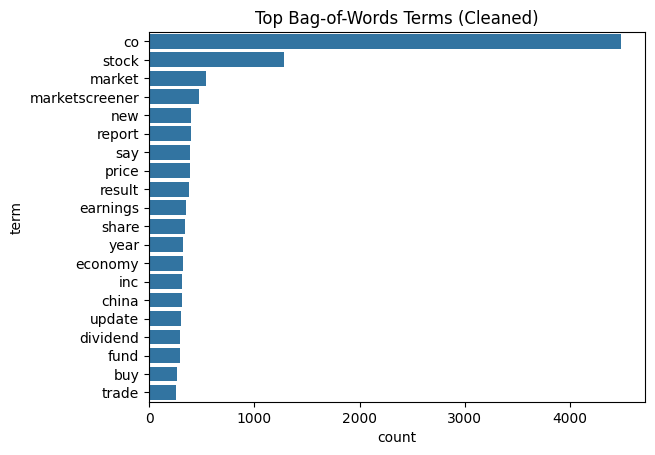

In [ ]:
# üîç Visualize top Bag of Words terms (Cleaned)
clean_bow_sum = np.array(X.sum(axis=0)).flatten()
clean_terms = bow.get_feature_names_out() # in older versions is get_feature_names()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term')
plt.title("Top Bag-of-Words Terms (Cleaned)")
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

In [ ]:
modelknn.fit(X,y)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [ ]:
test_sent = ["this is a horrible product", 'This is a bad product', 'This is a neutral product! just ok']

In [ ]:
test_clean = clean(test_sent, lemmatize=True, stemmer=False)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:00<?, ?it/s]


In [ ]:
test_clean

['horrible product', 'bad product', 'neutral product ok']

In [ ]:
test_model = bow.transform(test_sent)

In [ ]:
predict = modelknn.predict(test_sent)

ValueError: Expected 2D array, got 1D array instead:
array=['this is a horrible product' 'This is a bad product'
 'This is a neutral product! just ok'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
predict

array([2, 2, 2], dtype=int64)

In [ ]:
for review, score in zip(test_sent, predict):
    print(f'The predicted score for the review: "{review}", is {score}.')

The predicted score for the review: "this is a horrible product", is 2.
The predicted score for the review: "This is a bad product", is 2.
The predicted score for the review: "This is a neutral product! just ok", is 2.


In [ ]:
update_df(test, clean(test['text'], lemmatize = True, stemmer = False))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2388/2388 [00:00<00:00, 6531.17it/s]


In [ ]:
test

id                                               text
0        0  etf asset surge tenfold year trillion bank ame...
1        1  hedge fund think evolution petroleum corporati...
2        2  pvh phillips van heusen q earnings preview co ...
3        3  china process waiving retaliatory tariff impor...
4        4  highlight growth scarce investor seem willing ...
...    ...                                                ...
2383  2383  ivc invacare corporation ivc ceo matthew monag...
2384  2384                       domtar eps miss revenue line
2385  2385  india plan incentive ing foreign manufacturer ...
2386  2386  nvcr show institutional accumulation blue skys...
2387  2387  accesso technology form accesso technology gro...

[2388 rows x 2 columns]

In [ ]:
X_test = bow.transform(test['text'])
y_test = np.array(test['label'])

KeyError: 'label'